# A simple Client Credit Rating Model (Logistic Regression)

https://www.kaggle.com/datasets/satyajeetrai/credit-risk-dataset/data

Released under MIT License

Copyright (c) 2013 Mark Otto.

Copyright (c) 2017 Andrew Fong.

### Import Libraries

In [35]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

### Load from S3 Bucket

In [36]:
# Set bucket and file
bucket = 'creditrisk*****'
file_key = 'dataset.csv'

# Load from S3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=file_key)
df = pd.read_csv(obj['Body'])
df

,id,Duration in months,Credit history,Purpose of the credit,Credit amount,Status of savings account/bonds,Present employment(years),Installment rate in percentage of disposable income,personal_status,Other debtors / guarantors,...,Property,Age in years,Other installment plans (banks/stores),Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Status of existing checking account
0,1,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,2,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,3,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,4,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,5,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,997,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,998,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,999,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


### Remove unuseful variables

In [37]:
df = df.drop(['id','Purpose of the credit','Other debtors / guarantors','Number of people being liable to provide maintenance for'], axis=1)

### Prepare Data

In [38]:
# Target setup
target_column = 'Status of existing checking account'
df[target_column] = df[target_column].map({'good': 1, 'bad': 0})
X = df.drop(columns=[target_column])
y = df[target_column]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42)

# Column types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Transform
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
print(X_train_proc)

[[-0.25016831 -0.60956414  0.90766604 ...  0.          0.
   1.        ]
 [ 0.2423249   0.34283159 -1.79134091 ...  1.          0.
   1.        ]
 [-0.74266152 -0.7590354   0.90766604 ...  0.          0.
   1.        ]
 ...
 [ 0.48857151  0.05268149  0.00799706 ...  0.          0.
   1.        ]
 [ 1.22731132  2.53601466 -0.89167193 ...  0.          0.
   1.        ]
 [-0.74266152 -0.28881639 -0.89167193 ...  1.          0.
   1.        ]]


### Run Logistic Regression Model

In [39]:
# Model: Logistic Regression with class balancing
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_proc, y_train)

# Predict probabilities
y_prob = model.predict_proba(X_test_proc)[:, 1]

# Threshold tuning
threshold = 0.4
y_pred = (y_prob >= threshold).astype(int)

f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Print Results
print("\nEVALUATION METRICS")
print("=" * 50)
print(f"Threshold: {threshold}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['bad', 'good']))


EVALUATION METRICS
Threshold: 0.4
ROC AUC: 0.7214

Classification Report:
              precision    recall  f1-score   support

         bad       0.54      0.63      0.58        30
        good       0.83      0.77      0.80        70

    accuracy                           0.73       100
   macro avg       0.69      0.70      0.69       100
weighted avg       0.74      0.73      0.74       100



### Show Confusion Matrx

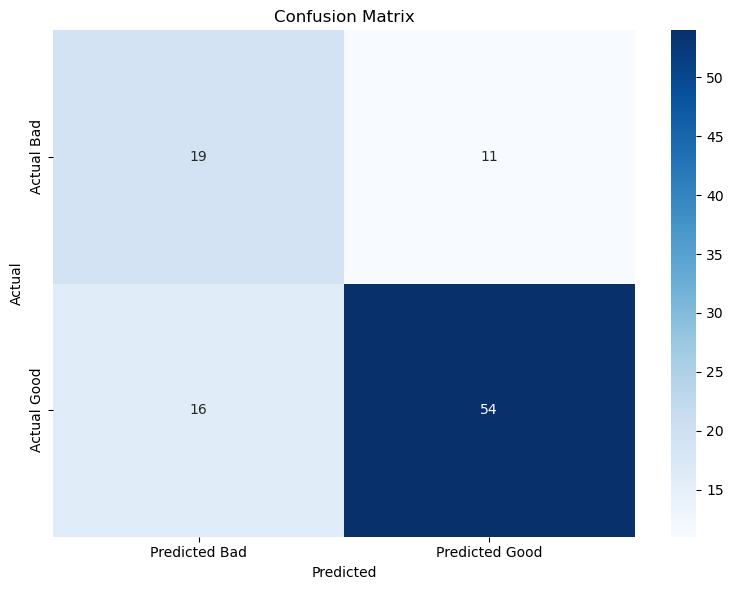

In [40]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Show ROC Curve

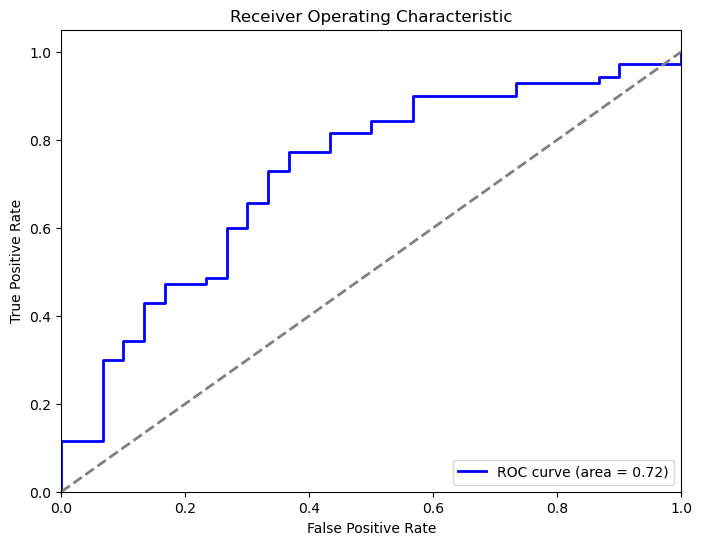

ROC AUC: 0.7214


In [41]:
# ROC curve
if auc is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

### Analyse Most Important Predictors

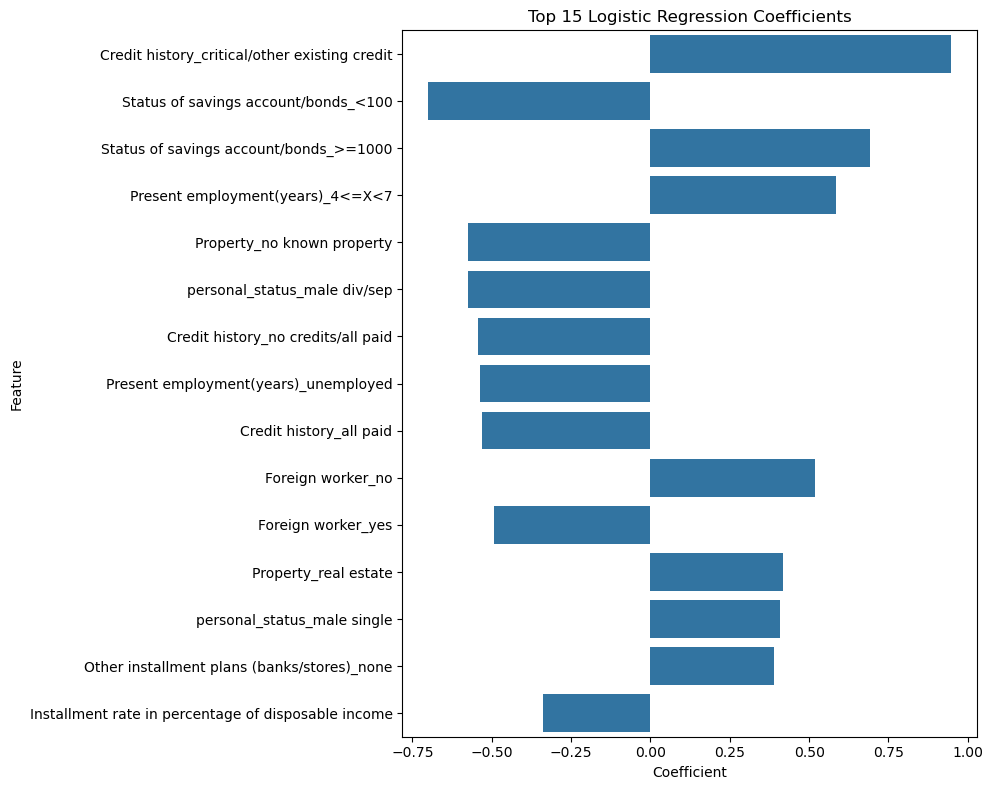

In [42]:
# Feature Importance (coefficients)
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)
coefficients = model.coef_[0]

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feat_imp_df.head(15))
plt.title('Top 15 Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

### Conclusions

As Expected the main problem of our model is the low recall for the "bad" credit class. Which, by the way, is the most impactful when we are concerned with credit risk as most of our losses will come from the uncovered accounts form bad credit and not the lost opportunities from the missclassified instancies of the "good" credit class. We will later try some different ML algorithms to achive better results